In [3]:
!pip install keras --upgrade

Requirement already up-to-date: keras in /usr/local/lib/python3.6/dist-packages
Requirement already up-to-date: numpy>=1.9.1 in /usr/local/lib/python3.6/dist-packages (from keras)
Requirement already up-to-date: six>=1.9.0 in /usr/local/lib/python3.6/dist-packages (from keras)
    100% |████████████████████████████████| 256kB 3.3MB/s 
    100% |████████████████████████████████| 50.0MB 27kB/s 
  Running setup.py bdist_wheel for pyyaml ... done
  Stored in directory: /content/.cache/pip/wheels/2c/f7/79/13f3a12cd723892437c0cfbde1230ab4d82947ff7b3839a4fc
Successfully built pyyaml
  Found existing installation: PyYAML 3.11
    Uninstalling PyYAML-3.11:
      Successfully uninstalled PyYAML-3.11
  Found existing installation: scipy 0.19.1
    Uninstalling scipy-0.19.1:
      Successfully uninstalled scipy-0.19.1


In [ ]:
import os
import random
import sys
import warnings
import numpy as np
import pandas as pd
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from keras.utils import Progbar

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose,Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras import optimizers
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import backend as K

import tensorflow as tf
warnings.filterwarnings('ignore', category=UserWarning, module='skimage')

# Setting seed for reproducability
SEED = 42
np.random.seed(SEED)

In [203]:
# get train_data
X_train,Y_train = read_train_data()
# get test_data
test_img,test_img_sizes = read_test_data()

from sklearn.model_selection import train_test_split
train_img, val_img, train_mask, val_mask = train_test_split(X_train, Y_train, test_size=0.25, random_state=SEED)

train_size = len(train_img)
val_size = len(val_img)

Getting and resizing train images and masks ... 
Train file loaded from memory

Getting and resizing test images ... 
Test file loaded from memory


In [ ]:
#@title Hyperparameters { run: "auto" }
BATCH_SIZE = 16 #@param {type:"integer"}
EPOCHS = 50 #@param {type:"integer"}
LEARNING_RATE = 1e-3 #@param {type:"raw"}
OPTIMIZER = optimizers.Adam(lr=LEARNING_RATE) #@param {type:"raw"}

In [ ]:
def get_unet(IMG_WIDTH=256,IMG_HEIGHT=256,IMG_CHANNELS=3):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = Lambda(lambda x: x / 255) (inputs)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (s)
    c1 = Dropout(0.1) (c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p1)
    c2 = Dropout(0.1) (c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p2)
    c3 = Dropout(0.2) (c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p3)
    c4 = Dropout(0.2) (c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p4)
    c5 = Dropout(0.3) (c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u6)
    c6 = Dropout(0.2) (c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u7)
    c7 = Dropout(0.2) (c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u8)
    c8 = Dropout(0.1) (c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u9)
    c9 = Dropout(0.1) (c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer=OPTIMIZER,loss='binary_crossentropy', metrics=[my_iou_metric])
    return model

In [208]:
# get u_net model
u_net = get_unet()
u_net.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
lambda_9 (Lambda)               (None, 256, 256, 3)  0           input_9[0][0]                    
__________________________________________________________________________________________________
conv2d_153 (Conv2D)             (None, 256, 256, 16) 448         lambda_9[0][0]                   
__________________________________________________________________________________________________
dropout_73 (Dropout)            (None, 256, 256, 16) 0           conv2d_153[0][0]                 
__________________________________________________________________________________________________
conv2d_154

Fit model on train data and save the best model.

In [209]:
print("\nTraining...")
filepath="weights.best.hdf5"
earlystopper = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
checkpointer = ModelCheckpoint(filepath, monitor='val_my_iou_metric', 
                               verbose=1, save_best_only=True, mode='max')
results = u_net.fit(x=train_img, y=train_mask, validation_data=(val_img, val_mask), 
                   batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1, 
                   callbacks=[earlystopper, checkpointer])


Training...
Train on 502 samples, validate on 168 samples
Epoch 1/50
502/502 [==============================] - 25s 49ms/step - loss: 0.6480 - my_iou_metric: 3.2744e-06 - val_loss: 0.6170 - val_my_iou_metric: 3.7913e-05

Epoch 00001: val_my_iou_metric improved from -inf to 0.00004, saving model to weights.best.hdf5
Epoch 2/50
502/502 [==============================] - 21s 41ms/step - loss: 0.5792 - my_iou_metric: 0.0000e+00 - val_loss: 0.5300 - val_my_iou_metric: 8.3836e-05

Epoch 00002: val_my_iou_metric improved from 0.00004 to 0.00008, saving model to weights.best.hdf5
Epoch 3/50
502/502 [==============================] - 20s 41ms/step - loss: 0.4317 - my_iou_metric: 0.0000e+00 - val_loss: 0.3959 - val_my_iou_metric: 0.0000e+00

Epoch 00003: val_my_iou_metric did not improve
Epoch 4/50
502/502 [==============================] - 20s 41ms/step - loss: 0.3555 - my_iou_metric: 0.0000e+00 - val_loss: 0.3442 - val_my_iou_metric: 0.0000e+00

Epoch 00004: val_my_iou_metric did not improve


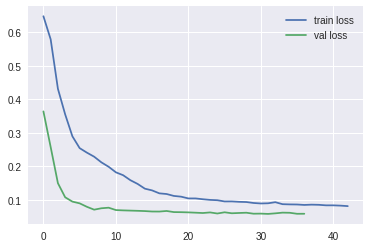

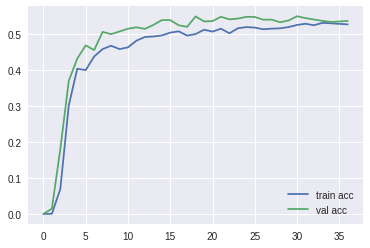

In [210]:
%matplotlib inline
import matplotlib.pyplot as plt 
loss = results.history['loss']
val_loss = result.history['val_loss']
acc = result.history['my_iou_metric']
val_acc = result.history['val_my_iou_metric']
plt.figure()
plt.plot(np.arange(len(loss)), np.array(loss), label='train loss')
plt.plot(np.arange(len(val_loss)), np.array(val_loss), label='val loss')
plt.legend(loc=1)

plt.figure()
plt.plot(np.arange(len(acc)), np.array(acc), label='train acc')
plt.plot(np.arange(len(val_acc)), np.array(val_acc), label='val acc')
plt.legend(loc=4)

# Plot train/val loss and train/val mean_iou

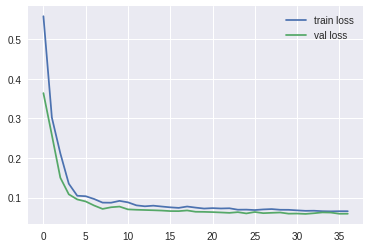

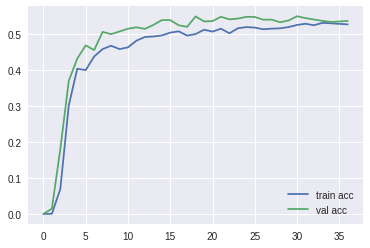

In [144]:
%matplotlib inline
import matplotlib.pyplot as plt 
loss = results.history['loss']
val_loss = result.history['val_loss']
acc = result.history['my_iou_metric']
val_acc = result.history['val_my_iou_metric']
plt.figure()
plt.plot(np.arange(len(loss)), np.array(loss), label='train loss')
plt.plot(np.arange(len(val_loss)), np.array(val_loss), label='val loss')
plt.legend(loc=1)

plt.figure()
plt.plot(np.arange(len(acc)), np.array(acc), label='train acc')
plt.plot(np.arange(len(val_acc)), np.array(val_acc), label='val acc')
plt.legend(loc=4)

# load best model and predict

In [211]:
# load best model
best_model = load_model('weights.best.hdf5', custom_objects={'my_iou_metric': my_iou_metric})

print("Predicting\n")
pred_train = best_model.predict(train_img, verbose=1)
pred_val = best_model.predict(val_img, verbose=1)
pred_test = best_model.predict(test_img, verbose=1)
# Compile model (required to make predictions)
# u_net.compile(loss='binary_crossentropy', optimizer='adam', metrics=[my_iou_metric])

Predicting
65/65 [==============================] - 1s 8ms/step


/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


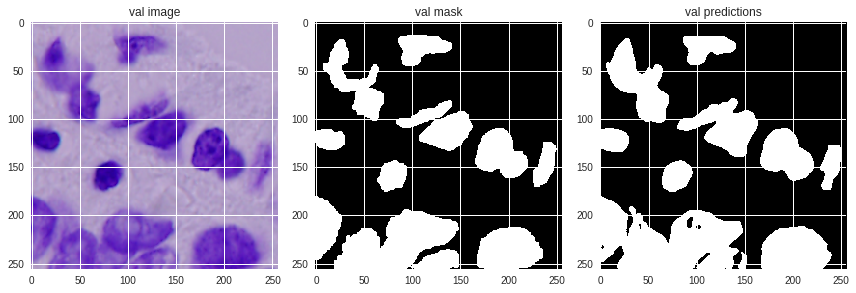

In [146]:
%matplotlib inline
import matplotlib.pyplot as plt 
idx = np.random.choice(range(len(val_img)))
plt.figure(figsize=(12,12))
plt.subplot(131)
imshow(val_img[idx])
plt.title("val image")
plt.subplot(132)
imshow(np.squeeze(val_mask[idx]))
plt.title("val mask")
plt.subplot(133)
imshow(np.squeeze(pred_val[idx] > 0.5))
plt.title("val predictions")
plt.show()

In [148]:
idx = np.random.choice(range(len(val_img)))

iou_metric(np.squeeze(val_mask[idx]), np.squeeze(pred_val[idx]), print_table=True)

Thresh	TP	FP	FN	Prec.
0.500	24	2	3	0.828
0.550	23	3	4	0.767
0.600	19	7	8	0.559
0.650	19	7	8	0.559
0.700	17	9	10	0.472
0.750	16	10	11	0.432
0.800	16	10	11	0.432
0.850	14	12	13	0.359
0.900	13	13	14	0.325
0.950	10	16	17	0.233
AP	-	-	-	0.497


0.4965519517983078

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


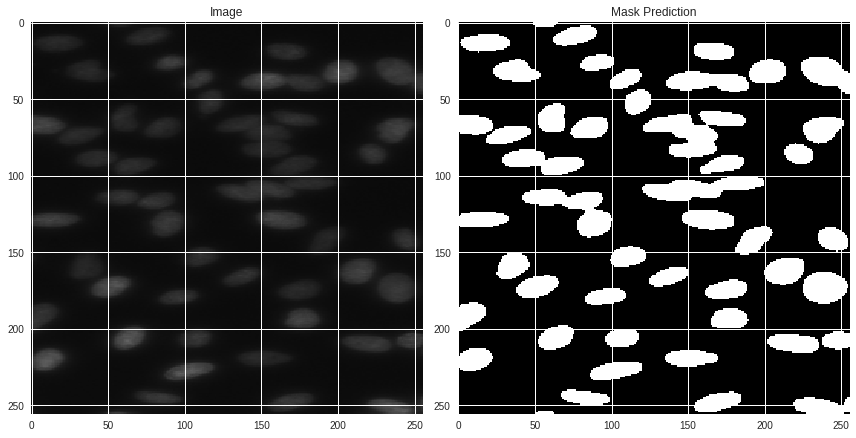

In [149]:
idx = np.random.choice(range(len(test_img)))
plt.figure(figsize=(12,12))
plt.subplot(121)
imshow(test_img[idx])
plt.title("Image")
plt.subplot(122)
imshow(np.squeeze(pred_test[idx] > 0.5))
plt.title("Mask Prediction")
plt.show()

# Train with data augmentation

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
data_gen_arg = dict(shear_range=0.5, 
                    rotation_range=50, 
                    zoom_range=0.2, 
                    width_shift_range=0.2, 
                    height_shift_range=0.2,
                    horizontal_flip=True,
                    vertical_flip=True,
                    fill_mode='reflect')


img_datagen = ImageDataGenerator(**data_gen_arg)
mask_datagen = ImageDataGenerator(**data_gen_arg)
img_datagen.fit(train_img, augment=True, seed=SEED)
mask_datagen.fit(train_mask, augment=True, seed=SEED)

x = img_datagen.flow(train_img, batch_size=BATCH_SIZE, shuffle=True, seed=SEED)
y = mask_datagen.flow(train_mask, batch_size=BATCH_SIZE, shuffle=True, seed=SEED)

img_datagen_val = ImageDataGenerator()
mask_datagen_val = ImageDataGenerator()
img_datagen_val.fit(val_img, augment=True, seed=SEED)
mask_datagen_val.fit(val_mask, augment=True, seed=SEED)

x_val = img_datagen_val.flow(val_img, batch_size=BATCH_SIZE, shuffle=True, seed=SEED)
y_val = img_datagen_val.flow(val_mask, batch_size=BATCH_SIZE, shuffle=True, seed=SEED)

train_generator = zip(x, y)
val_generator = zip(x_val, y_val)

# Visualizations of augmented image and mask

In [ ]:
tempx = x.next()
tempy = y.next()
tempx_val = x_val.next()
tempy_val = y_val.next()

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


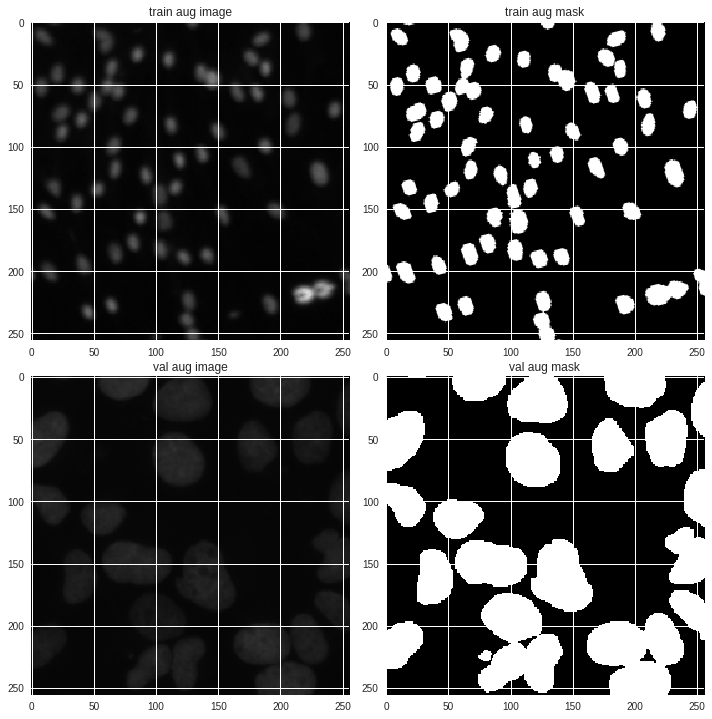

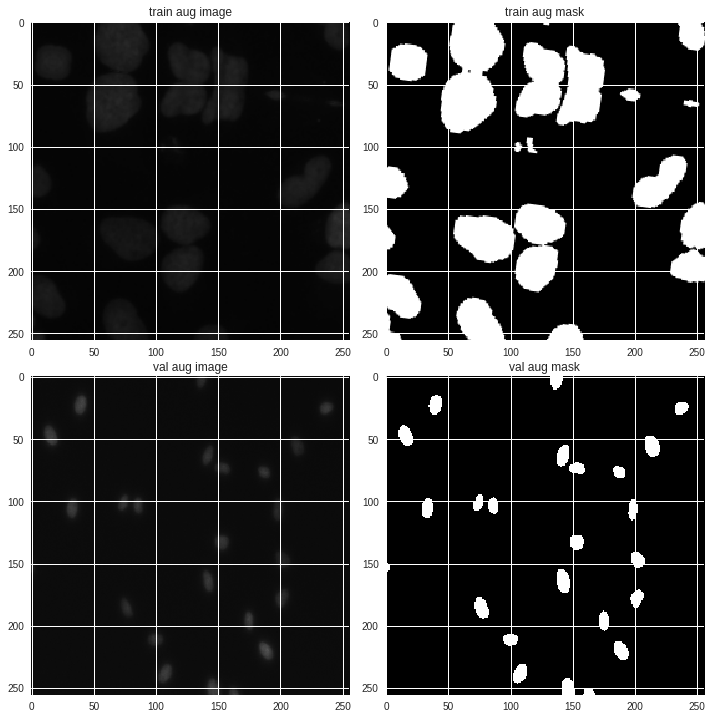

In [160]:
%matplotlib inline
import matplotlib.pyplot as plt
for i in range(2):
  plt.figure(figsize=(10,10))
  plt.subplot(221)
  imshow(tempx[i].astype(np.uint8))
  plt.title("train aug image")
  plt.subplot(222)
  imshow(np.squeeze(tempy[i]))
  plt.title("train aug mask")

  plt.subplot(223)
  imshow(tempx_val[i].astype(np.uint8))
  plt.title("val aug image")
  plt.subplot(224)
  imshow(np.squeeze(tempy_val[i]))
  plt.title("val aug mask")
  plt.show()

# Fit model with data augmentation

In [162]:
# get u_net model
u_net_aug = get_unet()
filepath="aug.weights.best.hdf5"
earlystopper = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
checkpointer = ModelCheckpoint(filepath, monitor='val_my_iou_metric',
                               verbose=1, save_best_only=True, mode='max')
results_aug = u_net_aug.fit_generator(train_generator, validation_data=val_generator, 
                    steps_per_epoch=train_size/BATCH_SIZE, validation_steps=val_size/BATCH_SIZE,
                   epochs=EPOCHS, callbacks=[earlystopper, checkpointer])

Epoch 1/50
34/33 [==============================] - 26s 752ms/step - loss: 0.6012 - my_iou_metric: 4.6744e-05 - val_loss: 0.4644 - val_my_iou_metric: 0.0000e+00

Epoch 00001: val_my_iou_metric improved from -inf to 0.00000, saving model to aug.weights.best.hdf5
Epoch 2/50
34/33 [==============================] - 21s 632ms/step - loss: 0.3398 - my_iou_metric: 0.0000e+00 - val_loss: 0.2735 - val_my_iou_metric: 0.0000e+00

Epoch 00002: val_my_iou_metric did not improve
Epoch 3/50
34/33 [==============================] - 22s 634ms/step - loss: 0.2964 - my_iou_metric: 7.1797e-05 - val_loss: 0.2311 - val_my_iou_metric: 0.0069

Epoch 00003: val_my_iou_metric improved from 0.00000 to 0.00685, saving model to aug.weights.best.hdf5
Epoch 4/50
34/33 [==============================] - 22s 636ms/step - loss: 0.2699 - my_iou_metric: 0.0135 - val_loss: 0.1807 - val_my_iou_metric: 0.2146

Epoch 00004: val_my_iou_metric improved from 0.00685 to 0.21458, saving model to aug.weights.best.hdf5
Epoch 5/50


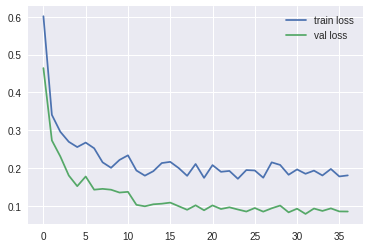

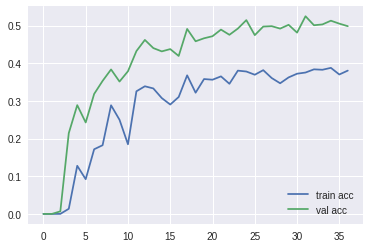

In [166]:
%matplotlib inline
import matplotlib.pyplot as plt 
loss = results_aug.history['loss']
val_loss = results_aug.history['val_loss']
acc = results_aug.history['my_iou_metric']
val_acc = results_aug.history['val_my_iou_metric']
plt.figure()
plt.plot(np.arange(len(loss)), np.array(loss), label='train loss')
plt.plot(np.arange(len(val_loss)), np.array(val_loss), label='val loss')
plt.legend(loc=1)

plt.figure()
plt.plot(np.arange(len(acc)), np.array(acc), label='train acc')
plt.plot(np.arange(len(val_acc)), np.array(val_acc), label='val acc')
plt.legend(loc=4)

In [167]:
# load best model
best_model_aug = load_model('aug.weights.best.hdf5', custom_objects={'my_iou_metric': my_iou_metric})

print("Predicting")
pred_train = best_model_aug.predict(train_img, verbose=1)
pred_val = best_model_aug.predict(val_img, verbose=1)
pred_test = best_model_aug.predict(test_img, verbose=1)

Predicting
65/65 [==============================] - 1s 8ms/step


/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


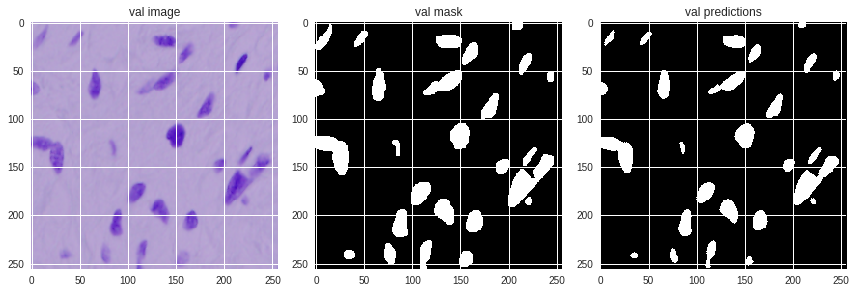

In [168]:
%matplotlib inline
import matplotlib.pyplot as plt 
idx = np.random.choice(range(len(val_img)))
plt.figure(figsize=(12,12))
plt.subplot(131)
imshow(val_img[idx])
plt.title("val image")
plt.subplot(132)
imshow(np.squeeze(val_mask[idx]))
plt.title("val mask")
plt.subplot(133)
imshow(np.squeeze(pred_val[idx] > 0.5))
plt.title("val predictions")
plt.show()

In [ ]:
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

In [ ]:
# Iterate over the test IDs and generate run-length encodings for each seperate mask identified by skimage
def mask_to_rle(preds_test_upsampled):
    new_test_ids = []
    rles = []
    for n, id_ in enumerate(test_ids):
        rle = list(prob_to_rles(preds_test_upsampled[n]))
        rles.extend(rle)
        new_test_ids.extend([id_] * len(rle))
    return new_test_ids,rles

In [ ]:
# Create list of upsampled test masks
test_mask_upsampled = []
for i in range(len(pred_test)):
    test_mask_upsampled.append(resize(np.squeeze(pred_test[i]),
                                       (test_img_sizes[i][0],test_img_sizes[i][1]), 
                                       mode='constant', preserve_range=True))

In [ ]:
test_ids,rles = mask_to_rle(test_mask_upsampled)

In [ ]:
# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))

sub.to_csv('sub-dsbowl2018.csv', index=False)

In [ ]:
# Code to download files from Google colab

from google.colab import files

files.download('sub-dsbowl2018.csv')
files.download('weights.best.hdf5')

In [ ]:
files.download('aug.weights.best.hdf5')